<div style="background-color:#0a2b45; color:white; padding:25px; border-radius:10px; 
            text-align:center; font-family:'Segoe UI', sans-serif;">

  <h1 style="margin-bottom:8px;">Amazing International Airlines Inc. ✈️</h1>
  <h3 style="margin-top:0; font-style:italic; font-weight:normal; color:#aad8e6;">
    Bonus Option 1 - Financial Impact Modeling
  </h3>

  <hr style="width:60%; border:1px solid #2fa6c9; margin:15px auto;">

  <p style="margin:5px 0; font-size:15px;">
    <b>Group 4</b> - Data Mining Project (2025/2026)
  </p>
  <p style="margin:0; font-size:13px; color:#b5c6d0;">
    Master in Data Science and Advanced Analytics - Nova Information Management School
  </p>
</div>

<br>

<div style="background-color:#132e3e; color:#e2e8f0; padding:15px 20px; border-left:5px solid #2fa6c9; 
            border-radius:6px; font-family:'Segoe UI', sans-serif; font-size:14px;">

  <b>👩‍💻 Project Authors</b><br>
  Pedro Santos - 20250399 - <a href="mailto:20250399@novaims.unl.pt" style="color:#80d0e0;">20250399@novaims.unl.pt</a><br>
  Miguel Correia - 20250381 - <a href="mailto:20250381@novaims.unl.pt" style="color:#80d0e0;">20250381@novaims.unl.pt</a><br>
  Pedro Fernandes - 20250418 - <a href="mailto:20250418@novaims.unl.pt" style="color:#80d0e0;">20250418@novaims.unl.pt</a><br>
  Tiago Duarte - 20250360 - <a href="mailto:20250360@novaims.unl.pt" style="color:#80d0e0;">20250360@novaims.unl.pt</a>
</div>

<br>

<div style="text-align:right; font-size:12px; color:#9ca3af;">
  Last updated: November 2025
</div>


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [7]:
df_clusters = pd.read_csv('data/final_clusters.csv', index_col=0)
df_clusters

,customer_count,Income,Customer Lifetime Value,Tenure,TotalFlightsWithCompanions,TotalPointsRedeemed,RedeemRatio,flights_period2,flights_period3,avg_monthly_flights,seasonality_score,trend%,is_active_pct,Province or State,Gender,Education,Location Code,Marital Status,LoyaltyStatus,EnrollmentType
merged_labels,,,,,,,,,,,,,,,,,,,,
0,1249,50705.119936,7244.953491,0.584307,5.160128,1028.849472,0.208909,2.104083,10.031225,1.712602,2.603387,58.193627,0.755004,Ontario,female,Bachelor,Suburban,Married,Star,Standard
1,1309,50445.700840,6555.040558,1.298319,23.088617,8687.577464,0.506023,14.963331,30.202445,7.628442,1.113109,306.070390,0.864782,Ontario,female,Bachelor,Rural,Married,Star,Standard
2,10626,49756.118276,7183.511107,4.023904,46.134199,11460.847915,0.304074,34.722850,45.289479,15.704014,0.756210,27.274795,0.978920,Ontario,male,Bachelor,Suburban,Married,Star,Standard
3,3503,49550.551013,7349.284412,1.376791,9.941193,1395.625464,0.079763,8.662575,11.549814,3.812053,0.694619,41.657162,0.618042,Ontario,female,Bachelor,Suburban,Married,Star,Standard


# 1. Customer Lifetime Value Statistics

Establish a baseline understanding of the current value of each customer segment by analyzing their Customer Lifetime Value (CLV). This analysis quantifies the total revenue each segment generates over their relationship with the airline, enabling strategic prioritization and investment decisions.

We leverage the existing CLV values from the dataset (`Customer Lifetime Value` variable) as our baseline, complemented by behavioral metrics to understand the drivers of value: `avg_monthly_flights`, `tenure`, and `is_active`.

**Annual Revenue Estimation:**
```
Annual Revenue = avg_monthly_flights × 12 × avg_ticket_price (€250)
```

**Retention Rate Estimation:**
Derived from activity levels and customer longevity:
```
Retention Rate = is_active_pct × (0.7 + 0.3 × min(tenure / 10, 1.0))
```
There is no closed formula for this metric. We opted to go with this one, giving 70% as base retention rate and giving the other 30% depending on the tenure.

**Customer Lifespan:**
Using the geometric series formula for expected duration:
```
Customer Lifespan (years) = 1 / (1 - Retention Rate)
```
Examples: 90% retention → 10-year lifespan | 80% retention → 5-year lifespan

**Total Segment Value:**
```
Total Segment Value = Baseline CLV × Customer Count
```

The analysis produces a table for each segment showing: Customer Count, Baseline CLV (€), Annual Revenue/Customer (€), Retention Rate (%), Expected Lifespan (years), and Total Segment Value (€).

This baseline CLV analysis enables segment prioritization, value comparison, and establishes the foundation for measuring improvements. Segments with high CLV and large customer counts represent the greatest current value. This represents the **"as-is" state** against which all improvement strategies will be measured.

In [8]:
def calculate_annual_revenue(avg_monthly_flights, avg_ticket_price=250):
    """Calculate estimated annual revenue per customer"""
    return avg_monthly_flights * 12 * avg_ticket_price


def calculate_retention_rate(is_active_pct, tenure):
    """Estimate retention rate from activity and tenure"""
    base_retention = is_active_pct
    tenure_factor = min(tenure / 10, 1.0)  # Max at 10 years
    return base_retention * (0.7 + 0.3 * tenure_factor)


def calculate_customer_lifespan(retention_rate, tenure):
    """Calculate expected customer lifespan in years"""
    if retention_rate < 1:
        return 1 / (1 - retention_rate)
    return tenure

In [9]:
def estimate_customer_lifetime_value_from_df(df_clusters, avg_ticket_price=250):
    results = []
    
    for label, row in df_clusters.iterrows():
        # Baseline CLV from dataset
        baseline_clv = row['Customer Lifetime Value']
        
        # Calculate underlying metrics
        annual_revenue = calculate_annual_revenue(row['avg_monthly_flights'], avg_ticket_price)
        retention_rate = calculate_retention_rate(row['is_active_pct'], row['Tenure'])
        customer_lifespan = calculate_customer_lifespan(retention_rate, row['Tenure'])
        
        # Total segment value
        total_customers = int(row['customer_count'])
        total_segment_value = baseline_clv * total_customers
        
        results.append({
            'Segment': f'Cluster_{int(label)}',
            'Customer Count': total_customers,
            'Baseline CLV (€)': round(baseline_clv, 0),
            'Annual Revenue/Customer (€)': round(annual_revenue, 0),
            'Retention Rate (%)': round(retention_rate * 100, 1),
            'Expected Lifespan (years)': round(customer_lifespan, 1),
            'Total Segment Value (€)': round(total_segment_value, 0)
        })
    
    return pd.DataFrame(results)


In [10]:
clv_df = estimate_customer_lifetime_value_from_df(df_clusters, avg_ticket_price=250)
clv_df

,Segment,Customer Count,Baseline CLV (€),Annual Revenue/Customer (€),Retention Rate (%),Expected Lifespan (years),Total Segment Value (€)
0,Cluster_0,1249,7245.0,5138.0,54.2,2.2,9048947.0
1,Cluster_1,1309,6555.0,22885.0,63.9,2.8,8580548.0
2,Cluster_2,10626,7184.0,47112.0,80.3,5.1,76331989.0
3,Cluster_3,3503,7349.0,11436.0,45.8,1.8,25744543.0


# 2. ROI Projections

To assess the financial impact of targeted investment strategies, we calculate the return on investment (ROI) for each of the four customer segments. The objective is to quantify the incremental value generated by specific improvements in customer behavior and to support the prioritization of segments with the highest profit potential.

The analysis is based on segment-level assumptions regarding investment intensity and expected behavioral changes, namely increased flight frequency and improved retention rates.

**Key inputs:**
- Investment per customer (€) - Direct spend on incentives, benefits, and engagement
- Expected frequency uplift (e.g., +20% more flights per year)
- Expected retention uplift (e.g., +12% higher retention rate)
- Baseline CLV (from previous analysis)

**Projection methodology:**

Starting from the baseline metrics established in the CLV estimation, we model the impact of targeted improvements:
```
Improved Annual Revenue = Current Annual Revenue × (1 + Frequency Uplift)
Improved Retention = Current Retention × (1 + Retention Uplift)
Improved Lifespan = 1 / (1 − Improved Retention)
Projected CLV = Improved Annual Revenue × Improved Lifespan
```

**ROI calculation:**

The incremental value represents the gain achieved through investment, measured against the baseline:
```
Incremental Value per Customer = Projected CLV − Baseline CLV
Total Incremental Value = Incremental Value per Customer × Customer Count
Total Investment = Investment per Customer × Customer Count
Net Benefit = Total Incremental Value − Total Investment
ROI (%) = (Net Benefit / Total Investment) × 100
```

**Payback period** is calculated as the number of months required to recover the initial investment based on the annual incremental value generated per customer.

The resulting analysis produces a table ranked by ROI%, showing: Baseline CLV, Projected CLV, Investment per Customer, Total Investment, Incremental Value per Customer, Total Incremental Value, Net Benefit, ROI (%), and Payback Period (months).

This ROI projection enables direct comparison of investment opportunities across segments, identifying which clusters offer the highest returns relative to required investment. Segments are prioritized based on both absolute net benefit and ROI percentage, balancing value creation with capital efficiency.

In [11]:
def project_annual_revenue(current_annual_revenue, freq_increase):
    """
    Project annual revenue per customer after frequency increase.
    """
    return current_annual_revenue * (1 + freq_increase)


def project_retention_rate(current_retention, retention_increase):
    """
    Project retention rate after improvement, capped at 100%.
    """
    return min(current_retention * (1 + retention_increase), 1)


def calculate_lifespan_from_retention(retention_rate, fallback_lifespan):
    """
    Calculate expected customer lifespan from retention rate.
    Uses geometric approximation when retention < 1.
    """
    if retention_rate < 1:
        return 1 / (1 - retention_rate)
    return fallback_lifespan * 1.2


def calculate_projected_clv(annual_revenue, lifespan):
    """
    Calculate projected CLV from annual revenue and lifespan.
    """
    return annual_revenue * lifespan


def calculate_roi_metrics(
    baseline_clv,
    projected_clv,
    investment_per_customer,
    total_customers,
    lifespan
):
    """
    Calculate incremental value, total investment, ROI and payback period.
    """
    incremental_value_per_customer = projected_clv - baseline_clv
    total_incremental_value = incremental_value_per_customer * total_customers
    total_investment = investment_per_customer * total_customers
    net_benefit = total_incremental_value - total_investment

    roi_percentage = (
        (net_benefit / total_investment) * 100
        if total_investment > 0 else 0
    )

    annual_incremental_value = (
        incremental_value_per_customer / lifespan
        if lifespan > 0 else 0
    )

    payback_months = (
        (investment_per_customer / annual_incremental_value) * 12
        if annual_incremental_value > 0 else np.inf
    )

    return {
        'Incremental Value per Customer (€)': incremental_value_per_customer,
        'Total Incremental Value (€)': total_incremental_value,
        'Total Investment (€)': total_investment,
        'Net Benefit (€)': net_benefit,
        'ROI (%)': roi_percentage,
        'Payback Period (months)': payback_months
    }

In [12]:
def calculate_roi_projections_from_clv(clv_df, strategies_dict):
    """
    Calculate ROI projections per customer segment based on CLV improvements
    driven by strategic initiatives.
    """
    results = []

    for _, clv_row in clv_df.iterrows():
        label = int(clv_row['Segment'].split('_')[1])


        if label not in strategies_dict:
            continue

        strategy = strategies_dict[label]

        # Baseline metrics
        baseline_clv = clv_row['Baseline CLV (€)']
        current_annual_rev = clv_row['Annual Revenue/Customer (€)']
        current_retention = clv_row['Retention Rate (%)'] / 100
        current_lifespan = clv_row['Expected Lifespan (years)']
        total_customers = clv_row['Customer Count']

        # Projections
        improved_annual_rev = project_annual_revenue(current_annual_rev,strategy['freq_increase'])

        improved_retention = project_retention_rate(current_retention,strategy['retention_increase'])

        improved_lifespan = calculate_lifespan_from_retention(improved_retention,current_lifespan)

        projected_clv = calculate_projected_clv(improved_annual_rev,improved_lifespan)

        # ROI & payback
        roi_metrics = calculate_roi_metrics(baseline_clv,projected_clv,strategy['investment'],total_customers,improved_lifespan)

        results.append({
            'Segment': clv_row['Segment'],
            'Projected CLV (€)': round(projected_clv, 0),
            'Improved Retention (%)': round(improved_retention * 100, 1),
            'Improved Lifespan (years)': round(improved_lifespan, 1),
            'Investment per Customer (€)': strategy['investment'],
            'Total Investment (€)': round(roi_metrics['Total Investment (€)'], 0),
            'Incremental Value per Customer (€)': round(roi_metrics['Incremental Value per Customer (€)'], 0),
            'Total Incremental Value (€)': round(roi_metrics['Total Incremental Value (€)'], 0),
            'ROI (%)': round(roi_metrics['ROI (%)'], 1),
            'Payback Period (months)': round(roi_metrics['Payback Period (months)'], 1)
        })

    return pd.DataFrame(results).sort_values('ROI (%)', ascending=False)

Based on the priorities described on the main notebokk:
**Resource Allocation Recommendation:**

- **60% resources -> Cluster 2**: Protect revenue backbone, maximize lifetime value
- **20% resources -> Cluster 1**: Invest in high-ROI growth acceleration
- **15% resources -> Cluster 3**: Focus on Premium subset rescue (732 customers)
- **5% resources -> Cluster 0**: Maintain seasonal touchpoints, minimal investment

We will use the following strategies:


In [13]:
total_budget = 1_000_000  
resource_allocation = {
    0: 0.05,  # 5% -> Cluster 0
    1: 0.20,  # 20% -> Cluster 1
    2: 0.60,  # 60% -> Cluster 2
    3: 0.15   # 15% -> Cluster 3
}

strategies = {}

for label in resource_allocation.keys():
    cluster_budget = total_budget * resource_allocation[label]
    
    customer_count = clv_df[clv_df['Segment'] == f'Cluster_{label}']['Customer Count'].values[0]
    
    investment_per_customer = cluster_budget / customer_count
    
    strategies[label] = {
        'investment': round(investment_per_customer, 2),
         # Cluster 1 with greatest potential
        'freq_increase': 0.40 if label == 1 else 0.15, 
        # Cluster 2 to protect retention
        'retention_increase': 0.15 if label == 2 else 0.12 
    }
    
roi_df = calculate_roi_projections_from_clv(clv_df, strategies)
roi_df

,Segment,Projected CLV (€),Improved Retention (%),Improved Lifespan (years),Investment per Customer (€),Total Investment (€),Incremental Value per Customer (€),Total Incremental Value (€),ROI (%),Payback Period (months)
2,Cluster_2,707757.0,92.3,13.1,56.47,600050.0,700573.0,7.444289e+09,1240511.0,0.0
1,Cluster_1,112686.0,71.6,3.5,152.79,200002.0,106131.0,1.389260e+08,69362.3,0.1
3,Cluster_3,27003.0,51.3,2.1,42.82,149998.0,19654.0,6.884695e+07,45798.4,0.1
0,Cluster_0,15036.0,60.7,2.5,40.03,49997.0,7791.0,9.731447e+06,19363.9,0.2


# 3. Cost-Benefit Analysis

To provide a comprehensive financial justification for the segmentation strategy, we decompose the total investment and expected returns into detailed cost and benefit categories. This granular breakdown enables transparent evaluation of resource allocation and value creation mechanisms across all four customer segments.

The analysis separates implementation costs into four distinct categories and benefits into four value drivers, providing stakeholders with clear visibility into where resources are deployed and how value is generated.

**Cost structure (4 categories):**

Implementation costs are allocated across the following components:

- **Technology (€):** CRM systems, analytics platforms, personalization tools, and system integrations required to operationalize segmentation strategies
- **Marketing (€):** Segment-specific campaigns, personalized content creation, multi-channel communication, and promotional activities
- **Operations (€):** Staff training, process redesign, customer service enhancements, and operational support infrastructure
- **Customer Incentives (€):** Direct investment per customer calculated as `Investment per Customer × Customer Count`, including loyalty rewards, upgrades, benefits, and engagement incentives

In [14]:
def calculate_cost_benefit_analysis_from_clv(clv_df, roi_df):

    costs = []
    benefits = []
    summary = []
    
    for idx, roi_row in roi_df.iterrows():
        seg_name = roi_row['Segment']
        
        # Get customer count from clv_df
        clv_row = clv_df[clv_df['Segment'] == seg_name].iloc[0]
        total_customers = clv_row['Customer Count']
        
        # Extract cluster label for priority determination
        label = int(seg_name.split('_')[1])
        
        # COSTS BREAKDOWN
        # Adjust costs based on segment priority/size
        # Cluster 1 (premium) gets higher tech/marketing, Cluster 2 (large) gets moderate, others minimal
        if label == 1:  # Premium High-Growth
            tech_cost = 50000
            marketing_cost = 100000
        elif label == 2:  # Large Core
            tech_cost = 80000  # Higher due to scale
            marketing_cost = 120000  # Higher due to scale
        else:
            tech_cost = 30000
            marketing_cost = 50000
        
        operations_cost = 20000
        incentives_total = roi_row['Investment per Customer (€)'] * total_customers
        total_cost = tech_cost + marketing_cost + operations_cost + incentives_total
        
        costs.append({
            'Segment': seg_name,
            'Technology (€)': tech_cost,
            'Marketing (€)': marketing_cost,
            'Operations (€)': operations_cost,
            'Customer Incentives (€)': round(incentives_total, 0),
            'Total Cost (€)': round(total_cost, 0)
        })
        
        # BENEFITS BREAKDOWN
        total_incremental_value = roi_row['Total Incremental Value (€)']
        
        # Decompose benefits (proportional allocation)
        revenue_increase = total_incremental_value * 0.60  # 60% from frequency increase
        retention_value = total_incremental_value * 0.25   # 25% from retention improvement
        efficiency_gains = 50000                            # Fixed efficiency savings
        cross_sell_value = total_incremental_value * 0.15  # 15% from cross-sell/upsell
        total_benefit = revenue_increase + retention_value + efficiency_gains + cross_sell_value
        
        benefits.append({
            'Segment': seg_name,
            'Revenue Increase (€)': round(revenue_increase, 0),
            'Retention Improvement (€)': round(retention_value, 0),
            'Efficiency Gains (€)': efficiency_gains,
            'Cross-sell/Upsell (€)': round(cross_sell_value, 0),
            'Total Benefit (€)': round(total_benefit, 0)
        })
        
        # SUMMARY (Cost vs Benefit)
        net_value = total_benefit - total_cost
        benefit_cost_ratio = total_benefit / total_cost if total_cost > 0 else 0
        
        summary.append({
            'Segment': seg_name,
            'Total Cost (€)': round(total_cost, 0),
            'Total Benefit (€)': round(total_benefit, 0),
            'Net Value (€)': round(net_value, 0),
            'Benefit/Cost Ratio': round(benefit_cost_ratio, 2)
        })
    
    costs_df = pd.DataFrame(costs)
    benefits_df = pd.DataFrame(benefits)
    summary_df = pd.DataFrame(summary)
    
    return costs_df, benefits_df, summary_df

In [15]:
# Calcular cost-benefit analysis (usa clv_df e roi_df já calculados)
costs_df, benefits_df, summary_df = calculate_cost_benefit_analysis_from_clv(clv_df, roi_df)
costs_df

,Segment,Technology (€),Marketing (€),Operations (€),Customer Incentives (€),Total Cost (€)
0,Cluster_2,80000,120000,20000,600050.0,820050.0
1,Cluster_1,50000,100000,20000,200002.0,370002.0
2,Cluster_3,30000,50000,20000,149998.0,249998.0
3,Cluster_0,30000,50000,20000,49997.0,149997.0



| Column                  | Description                                                                                  |
|-------------------------|----------------------------------------------------------------------------------------------|
| **Technology (€)**      | Technology-related costs (software, systems, infrastructure) for this segment.              |
| **Marketing (€)**       | Marketing and acquisition costs for the segment (campaigns, promotions, ads).               |
| **Operations (€)**      | Internal operational costs (training, process improvements, customer service support).       |
| **Customer Incentives (€)** | Direct incentives to customers (discounts, rewards), calculated per customer × total customers. |
| **Total Cost (€)**      | Sum of all costs for the segment (Technology + Marketing + Operations + Customer Incentives). |

In [16]:
benefits_df

,Segment,Revenue Increase (€),Retention Improvement (€),Efficiency Gains (€),Cross-sell/Upsell (€),Total Benefit (€)
0,Cluster_2,4.466573e+09,1.861072e+09,50000,1.116643e+09,7.444339e+09
1,Cluster_1,8.335561e+07,3.473150e+07,50000,2.083890e+07,1.389760e+08
2,Cluster_3,4.130817e+07,1.721174e+07,50000,1.032704e+07,6.889695e+07
3,Cluster_0,5.838868e+06,2.432862e+06,50000,1.459717e+06,9.781447e+06


| Column                        | Description                                                                                       |
|-------------------------------|---------------------------------------------------------------------------------------------------|
| **Revenue Increase (€)**       | Incremental revenue generated by increasing travel frequency for this segment.                 |
| **Retention Improvement (€)**  | Added value from improved customer retention (e.g., fewer churned customers).                     |
| **Efficiency Gains (€)**       | Savings from operational efficiencies (fixed value for all segments).                             |
| **Cross-sell/Upsell (€)**      | Additional revenue from cross-selling or upselling to existing customers.                        |
| **Total Benefit (€)**          | Total benefits for the segment (Revenue Increase + Retention Improvement + Cross-sell/Upsell). |

In [17]:
summary_df

,Segment,Total Cost (€),Total Benefit (€),Net Value (€),Benefit/Cost Ratio
0,Cluster_2,820050.0,7.444339e+09,7.443519e+09,9077.91
1,Cluster_1,370002.0,1.389760e+08,1.386060e+08,375.61
2,Cluster_3,249998.0,6.889695e+07,6.864695e+07,275.59
3,Cluster_0,149997.0,9.781447e+06,9.631450e+06,65.21


| Column                        | Description                                                                                       |
|-------------------------------|---------------------------------------------------------------------------------------------------|
| **Total Cost (€)**             | Total cost for the segment.                                                      |
| **Total Benefit (€)**          | Total benefit for the segment.                                               |
| **Net Value (€)**              | Difference between Total Benefit and Total Cost (Net Value = Total Benefit − Total Cost).        |
| **Benefit/Cost Ratio**         | Ratio of Total Benefit to Total Cost, indicating efficiency of investment (Total Benefit ÷ Total Cost). |

# 4. Investment Timeline with Expected Returns

In [18]:
def create_investment_timeline(roi_df, implementation_phases=None):
    if implementation_phases is None:
        # Default phased rollout based on strategic priorities
        implementation_phases = {
            2: {'phase': 'Phase 1: Protect & Grow', 'start_month': 0, 'duration_months': 3, 'priority': 'Tier 1'},
            1: {'phase': 'Phase 1: Protect & Grow', 'start_month': 0, 'duration_months': 3, 'priority': 'Tier 1'},
            0: {'phase': 'Phase 2: Activate & Convert', 'start_month': 3, 'duration_months': 3, 'priority': 'Tier 2'},
            3: {'phase': 'Phase 3: Rescue & Recover', 'start_month': 6, 'duration_months': 4, 'priority': 'Tier 3'}
        }
    
    timeline_data = []
    
    for idx, row in roi_df.iterrows():
        label = int(row['Segment'].split('_')[1])
        phase_info = implementation_phases[label]
        
        timeline_data.append({
            'Segment': row['Segment'],
            'Phase': phase_info['phase'],
            'Priority': phase_info['priority'],
            'Start Month': phase_info['start_month'],
            'Duration (months)': phase_info['duration_months'],
            'End Month': phase_info['start_month'] + phase_info['duration_months'],
            'Investment (€)': row['Total Investment (€)'],
            'Expected Return (€)': row['Total Incremental Value (€)'],
            'ROI (%)': row['ROI (%)'],
            'Customer Count': row['Segment'].split('_')[0]  # For reference
        })
    
    df = pd.DataFrame(timeline_data)
    return df.sort_values(['Start Month', 'Priority'])


def create_timeline_gantt(timeline_df):
    """
    Create Gantt-style timeline visualization with vertical phase labels
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), 
                                     gridspec_kw={'height_ratios': [3, 2]})
    
    # Color scheme by phase
    phase_colors = {
        'Phase 1: Protect & Grow': '#2E7D32',      # Dark green
        'Phase 2: Activate & Convert': '#1976D2',   # Blue
        'Phase 3: Rescue & Recover': '#F57C00'      # Orange
    }
    
    segments = timeline_df['Segment'].values
    y_positions = range(len(segments))
    
    # Group segments by phase for visual separation
    phase_groups = {}
    for idx, row in timeline_df.iterrows():
        phase = row['Phase']
        if phase not in phase_groups:
            phase_groups[phase] = []
        phase_groups[phase].append(list(segments).index(row['Segment']))
    
    # Draw phase labels on LEFT side (vertical orientation)
    for phase, positions in phase_groups.items():
        # Phase background shading
        min_pos = min(positions) - 0.5
        max_pos = max(positions) + 0.5
        ax1.axhspan(min_pos, max_pos, alpha=0.08, color=phase_colors[phase])
        
        # Phase label on LEFT side (vertical text)
        mid_pos = (min_pos + max_pos) / 2
        ax1.text(-1.5, mid_pos, phase,
                rotation=0, va='center', ha='center',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.4', 
                         facecolor=phase_colors[phase], 
                         alpha=0.8, edgecolor='black', linewidth=1.5))
    
    # Top chart: Implementation timeline (Gantt bars)
    for idx, row in timeline_df.iterrows():
        y_pos = list(segments).index(row['Segment'])
        
        # Implementation bar
        ax1.barh(y_pos, row['Duration (months)'], 
                left=row['Start Month'],
                height=0.7,
                color=phase_colors[row['Phase']],
                alpha=0.85,
                edgecolor='black',
                linewidth=1.5)
        
        # Investment annotation (white text inside bar)
        bar_center = row['Start Month'] + row['Duration (months)']/2
        ax1.text(bar_center, y_pos,
                f"€{row['Investment (€)']/1000:.0f}K",
                ha='center', va='center', 
                fontweight='bold', fontsize=11,
                color='white')
    
    # Segment labels on left (with more space for phase labels)
    ax1.set_yticks(y_positions)
    ax1.set_yticklabels(segments, fontsize=11, fontweight='bold')
    ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax1.set_title('Customer Segmentation Strategy - Implementation Timeline', 
                  fontsize=15, fontweight='bold', pad=25)  # Increased pad
    ax1.set_xlim(-2.5, 12.5)  # Extra space on left for phase labels
    ax1.set_ylim(-0.8, len(segments))  # Adjusted to give more space at top
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2.5, alpha=0.7, label='Project Start')
    ax1.legend(loc='upper left', fontsize=10)
    
    # Add vertical lines for quarters and labels at VERY top (above bars)
    for month in [0, 3, 6, 9, 12]:
        ax1.axvline(x=month, color='gray', linestyle='-', linewidth=0.8, alpha=0.4)
        if month in [0, 3, 6, 9]:
            quarter = month // 3 + 1
            # Position quarters ABOVE the top cluster
            ax1.text(month + 1.5, len(segments) - 0.2, f'Q{quarter}', 
                    ha='center', va='bottom', fontsize=11, 
                    fontweight='bold', color='#555',
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor='white', 
                             edgecolor='gray',
                             alpha=0.9))
    
    # Bottom chart: Cumulative investment and returns
    months = range(0, 13)
    cumulative_investment = []
    cumulative_returns = []
    
    for month in months:
        # Calculate cumulative investment up to this month
        invest = timeline_df[timeline_df['Start Month'] <= month]['Investment (€)'].sum()
        cumulative_investment.append(invest)
        
        # Calculate cumulative returns (with 6-month ramp-up)
        returns = 0
        for idx, row in timeline_df.iterrows():
            if month >= row['Start Month']:
                months_active = month - row['Start Month']
                ramp_factor = min(1.0, months_active / 6)  # Full effect at 6 months
                monthly_return = (row['Expected Return (€)'] / 12) * ramp_factor
                returns += monthly_return * months_active
        cumulative_returns.append(returns)
    
    ax2.plot(months, [x/1e6 for x in cumulative_investment], 
            marker='o', linewidth=3, label='Cumulative Investment',
            color='#D32F2F', markersize=8, markeredgecolor='black', markeredgewidth=1)
    ax2.plot(months, [x/1e6 for x in cumulative_returns],
            marker='s', linewidth=3, label='Cumulative Returns',
            color='#388E3C', markersize=8, markeredgecolor='black', markeredgewidth=1)
    ax2.fill_between(months, [x/1e6 for x in cumulative_investment], 
                     [x/1e6 for x in cumulative_returns],
                     alpha=0.2, color='green')
    
    ax2.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Value (€ Millions)', fontsize=12, fontweight='bold')
    ax2.set_title('Cumulative Investment vs. Returns', fontsize=13, fontweight='bold', pad=15)
    ax2.legend(loc='upper left', fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 12)
    
    # Add break-even marker
    for i in range(1, len(cumulative_returns)):
        if cumulative_returns[i] > cumulative_investment[i]:
            ax2.axvline(x=i, color='gold', linestyle='--', linewidth=2.5, 
                       alpha=0.8, label=f'Break-even: Month {i}')
            ax2.legend(loc='upper left', fontsize=11, framealpha=0.9)
            break
    
    plt.tight_layout()
    return fig

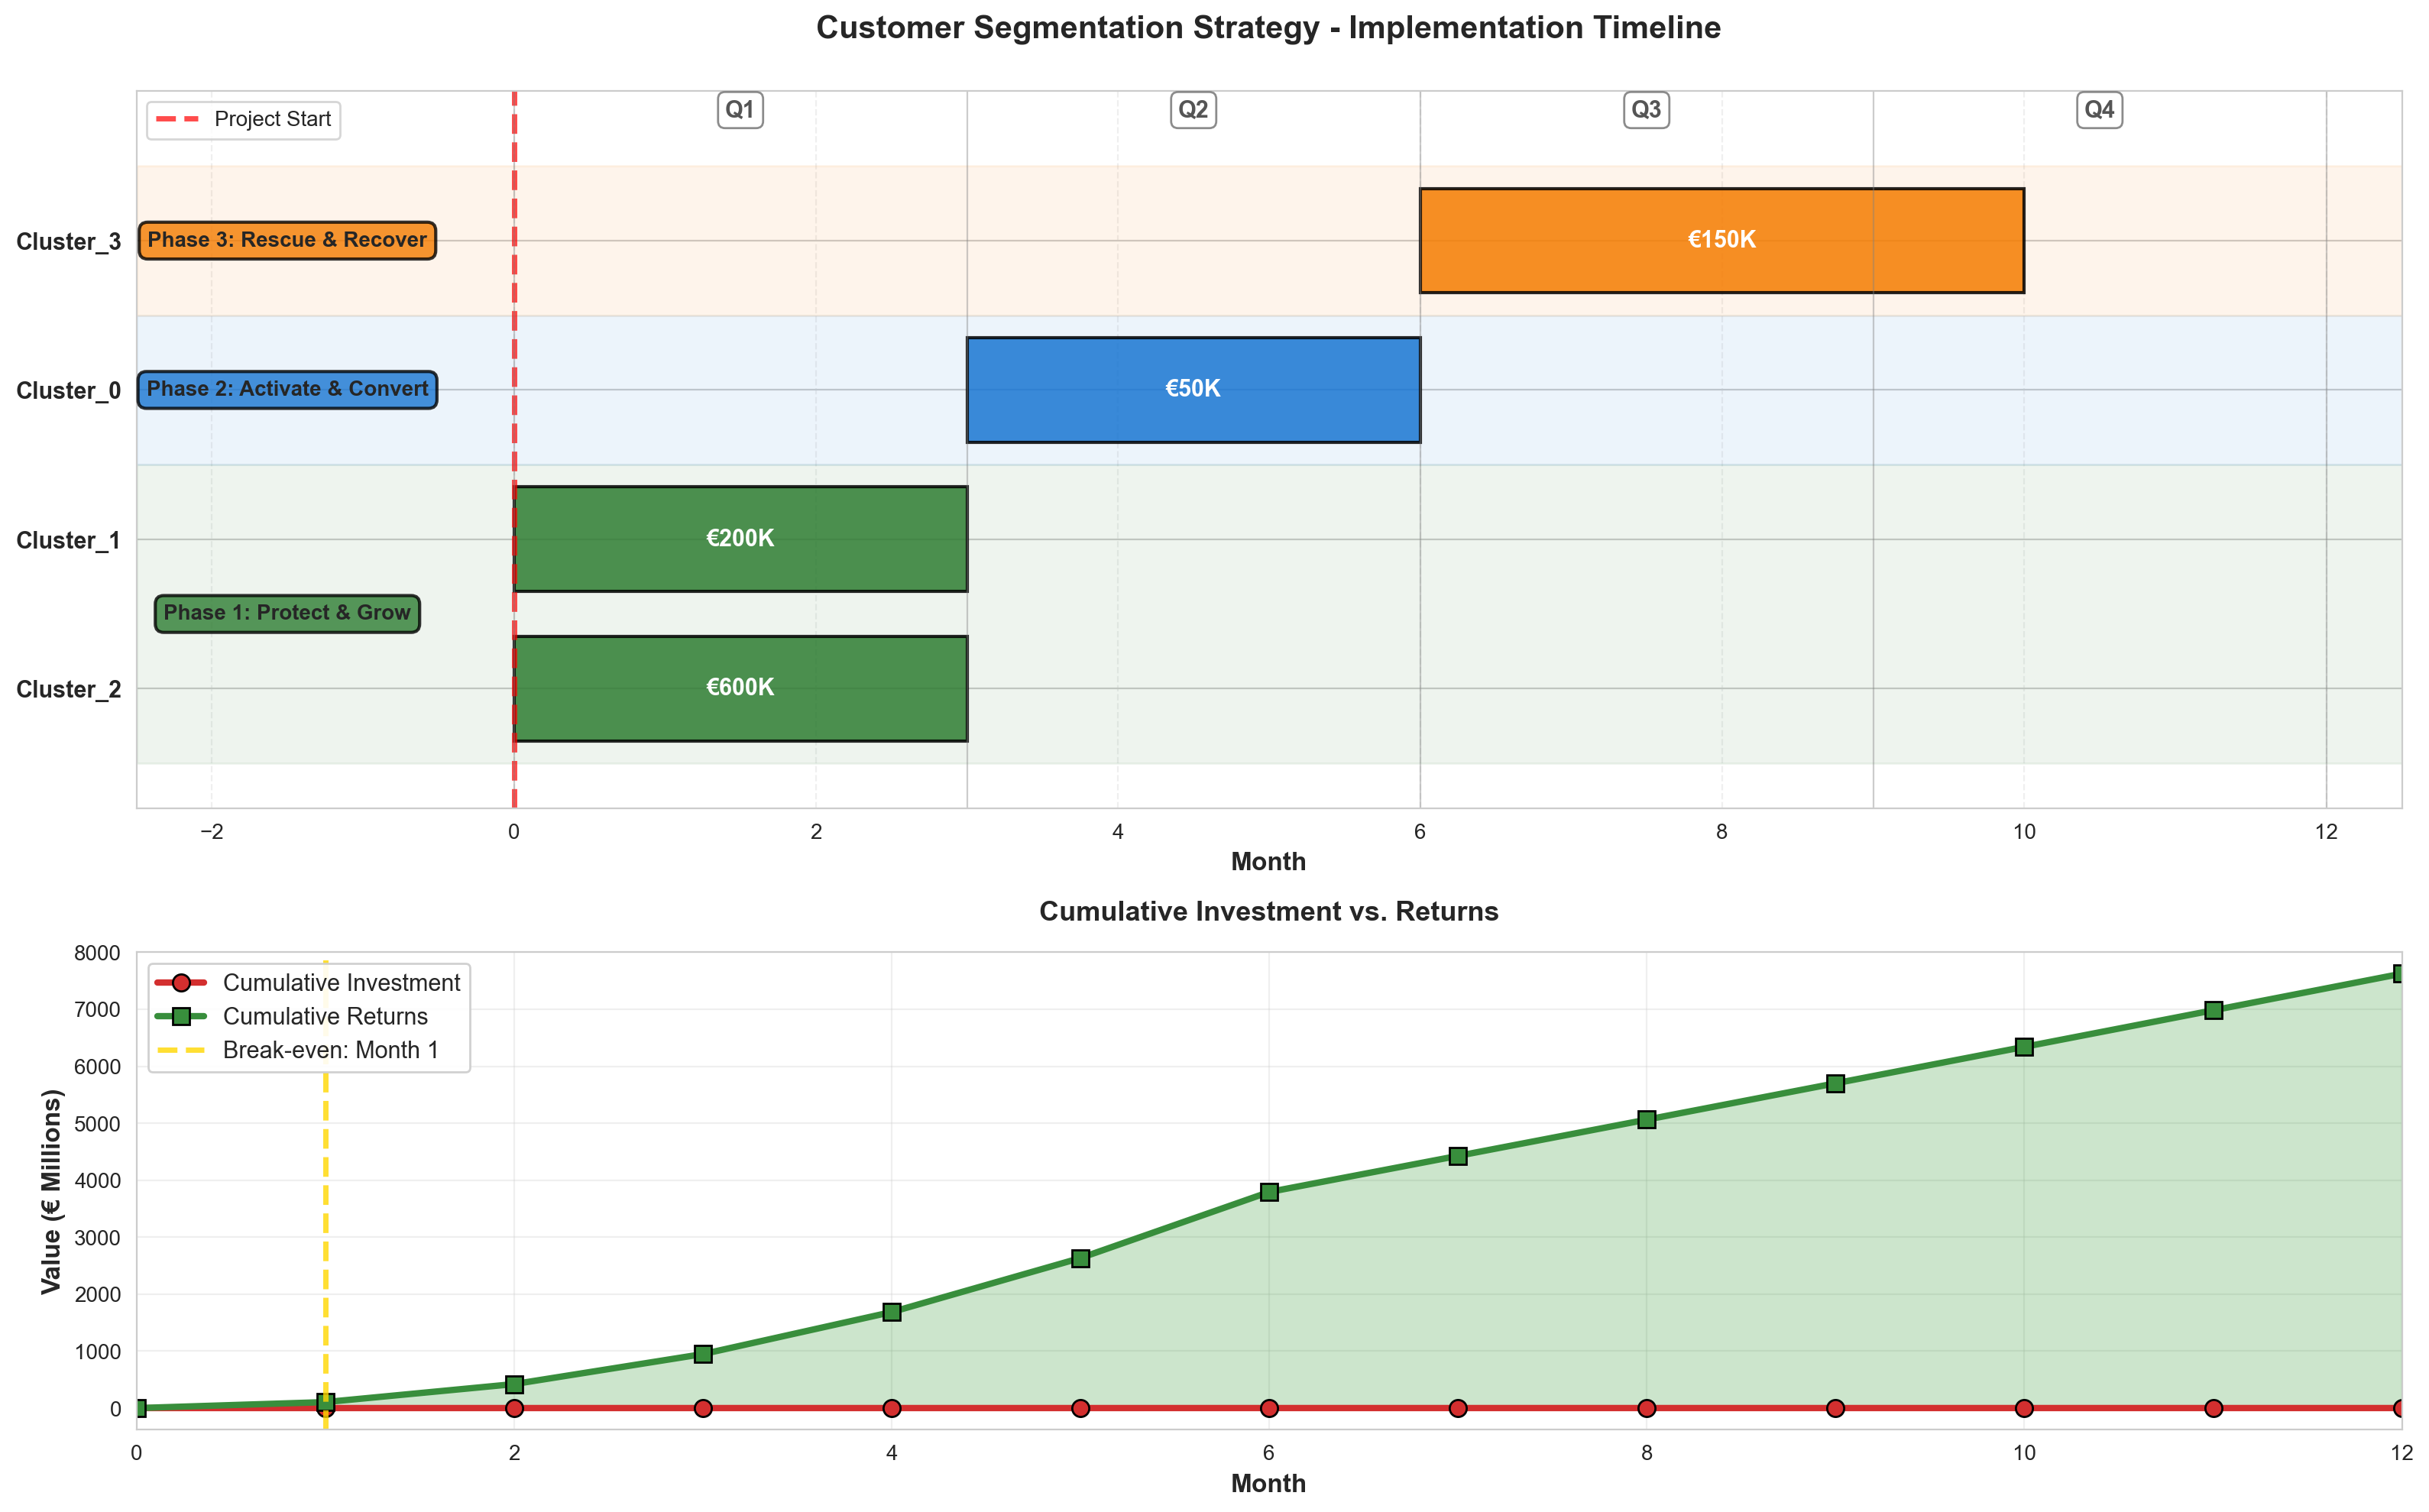

In [19]:
timeline_df = create_investment_timeline(roi_df)

fig = create_timeline_gantt(timeline_df)
plt.show()        

---

<h1 style="text-align: center;">End of Notebook</h1>

<p style="text-align: center; font-size: 18px;">Thank you for your time.</p>

---